<a href="https://colab.research.google.com/github/edugalt/hSBM_Topicmodel/blob/master/TopSBM-colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing Graph-Tool in Colab

[https://colab.research.google.com/github/count0/colab-gt/blob/master/colab-gt.ipynb#scrollTo=ccAj89hUOqoU](https://colab.research.google.com/github/count0/colab-gt/blob/master/colab-gt.ipynb#scrollTo=ccAj89hUOqoU)

In [ ]:
!wget https://downloads.skewed.de/skewed-keyring/skewed-keyring_1.0_all_$(lsb_release -s -c).deb
!dpkg -i skewed-keyring_1.0_all_$(lsb_release -s -c).deb
!echo "deb [signed-by=/usr/share/keyrings/skewed-keyring.gpg] https://downloads.skewed.de/apt $(lsb_release -s -c) main" > /etc/apt/sources.list.d/skewed.list
!apt-get update
!apt-get install python3-graph-tool python3-matplotlib python3-cairo

In [ ]:
# Colab uses a Python install that deviates from the system's! Bad colab! We need some workarounds.
!apt purge python3-cairo
!apt install libcairo2-dev pkg-config python3-dev
!pip install --force-reinstall pycairo
!pip install zstandard

In [ ]:
# Copying topSBM to Colab
!git clone https://github.com/edugalt/hSBM_Topicmodel.git
!cp hSBM_Topicmodel/data/corpus.txt .
!cp hSBM_Topicmodel/data/titles.txt .
!cp hSBM_Topicmodel/sbmtm.py .

# TopSBM: Topic Modeling with Stochastic Block Models

A basic tutorial.


In [1]:
%load_ext autoreload
%autoreload 2

import os
import pylab as plt
%matplotlib inline

from sbmtm import sbmtm
import graph_tool.all as gt

# Setup: Load a corpus

1) We have a list of documents, each document contains a list of words.

2) We have a list of document titles (optional)

The example corpus consists of 63 articles from Wikipedia taken from 3 different categories (Experimental Physics, Chemical Physics, and Computational Biology).



In [2]:
path_data = 'data/'

## texts
fname_data = 'corpus.txt'
filename = os.path.join(path_data,fname_data)

with open(filename,'r', encoding = 'utf8') as f:
    x = f.readlines()
texts = [h.split() for h in x]

## titles
fname_data = 'titles.txt'
filename = os.path.join(path_data,fname_data)

with open(filename,'r', encoding = 'utf8') as f:
    x = f.readlines()
titles = [h.split()[0] for h in x]

In [3]:
i_doc = 0
print(titles[0])
print(texts[i_doc][:20])

Nuclear_Overhauser_effect
['the', 'nuclear', 'overhauser', 'effect', 'noe', 'is', 'the', 'transfer', 'of', 'nuclear', 'spin', 'polarization', 'from', 'one', 'nuclear', 'spin', 'population', 'to', 'another', 'via']


# Fitting the model

In [4]:
## we create an instance of the sbmtm-class
model = sbmtm()

## we have to create the word-document network from the corpus
model.make_graph(texts,documents=titles)

## we can also skip the previous step by saving/loading a graph
# model.save_graph(filename = 'graph.xml.gz')
# model.load_graph(filename = 'graph.xml.gz')

## fit the model
gt.seed_rng(32) ## seed for graph-tool's random number generator --> same results
model.fit()

<NestedBlockState object, with base <BlockState object with 3203 blocks (123 nonempty), degree-corrected, for graph <Graph object, undirected, with 3203 vertices and 13050 edges, 2 internal vertex properties, 1 internal edge property, at 0x79237c7b7ec0>, at 0x792294389100>, and 5 levels of sizes [(3203, 123), (123, 27), (27, 5), (5, 2), (2, 1)] at 0x79237c7d4590>


# Plotting the result

The output shows the (hierarchical) community structure in the word-document network as inferred by the stochastic block model:

- document-nodes are on the left
- word-nodes are on the right
- different colors correspond to the different groups

The result is a grouping of nodes into groups on multiple levels in the hierarchy:

- on the uppermost level, each node belongs to the same group (square in the middle)
- on the next-lower level, we split the network into two groups: the word-nodes and the document-nodes (blue sqaures to the left and right, respectively). This is a trivial structure due to the bipartite character of the network.
- only next lower levels constitute a non-trivial structure: We now further divide nodes into smaller groups (document-nodes into document-groups on the left and word-nodes into word-groups on the right)

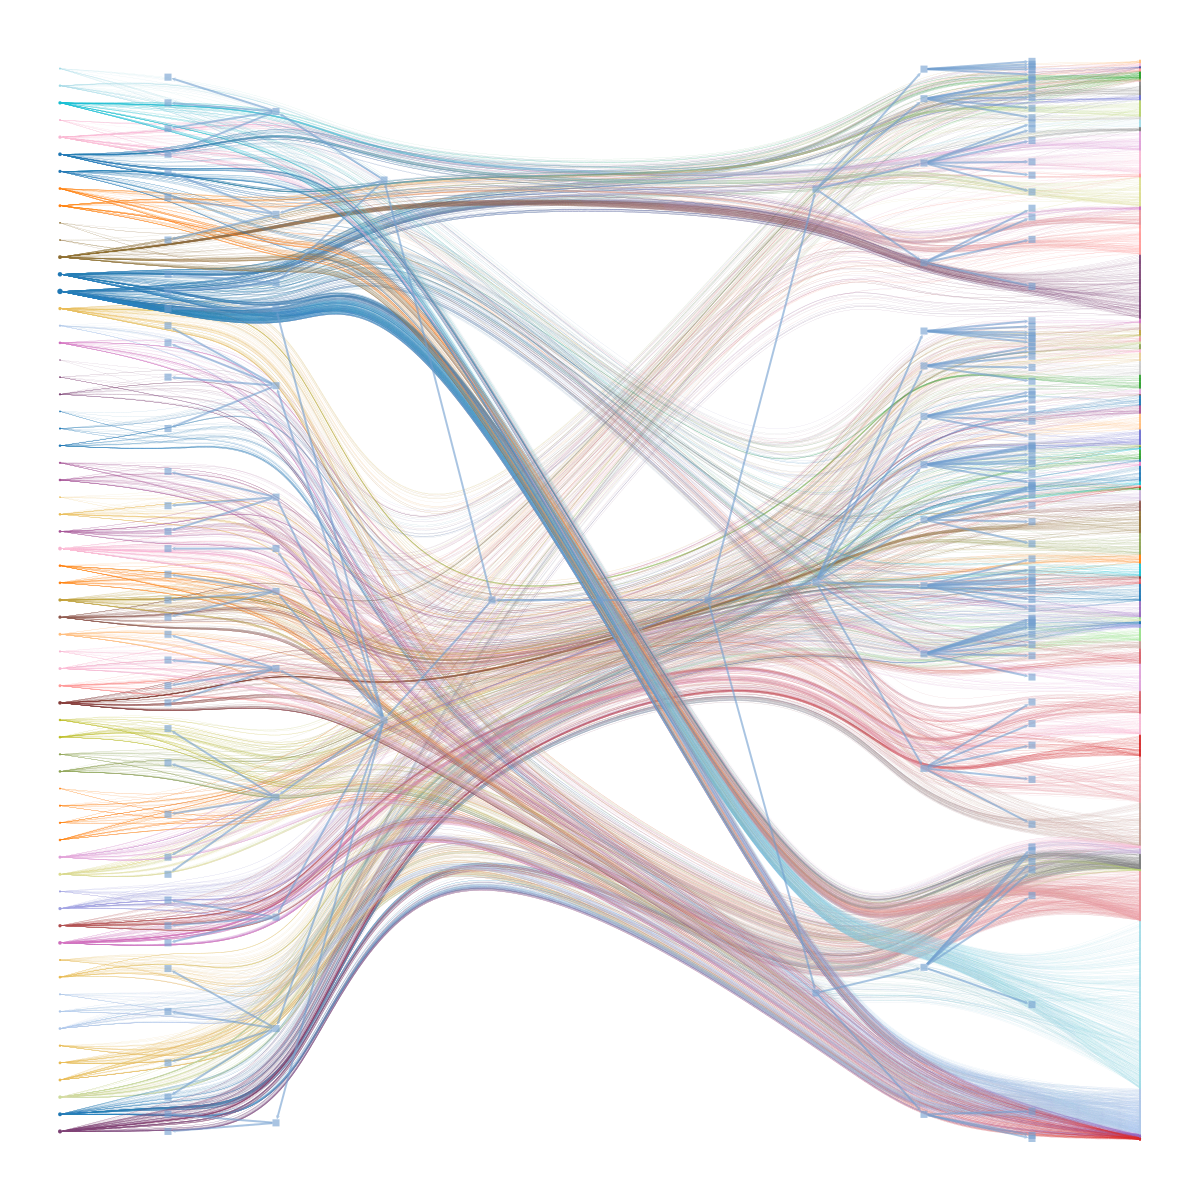

In [5]:
model.plot(nedges=5000)

# The basics

## Topics
For each word-group on a given level in the hierarchy, we retrieve the $n$ most common words in each group -- these are the topics!


In [6]:
model.topics(l=1,n=10)

{0: [('the', 0.20760347735824575),
  ('of', 0.11716621253405994),
  ('a', 0.06799013883482548),
  ('to', 0.06591410406124303),
  ('in', 0.0635136888542883),
  ('is', 0.05261450629298041),
  ('as', 0.025885558583106268),
  ('that', 0.02095497599584793),
  ('are', 0.020046710782405604),
  ('by', 0.018554560788893212)],
 1: [('formula', 0.13903394255874674),
  ('electron', 0.03981723237597911),
  ('x', 0.033942558746736295),
  ('spin', 0.030678851174934726),
  ('surface', 0.030026109660574413),
  ('magnetic', 0.026762402088772844),
  ('electrons', 0.022845953002610966),
  ('effect', 0.022193211488250653),
  ('ray', 0.02154046997389034),
  ('nuclear', 0.018929503916449087)],
 2: [('analysis', 0.09090909090909091),
  ('chemical', 0.039160839160839164),
  ('angle', 0.026573426573426574),
  ('proton', 0.025174825174825177),
  ('shown', 0.025174825174825177),
  ('loss', 0.016783216783216783),
  ('fermi', 0.016783216783216783),
  ('elements', 0.016783216783216783),
  ('empirical', 0.01538461538

## Topic-distribution in each document
Which topics contribute to each document?

In [7]:
## select a document (by its index)
i_doc = 0
print(model.documents[i_doc])
## get a list of tuples (topic-index, probability)
model.topicdist(i_doc,l=2)

Nuclear_Overhauser_effect


[(0, 0.5314685314685315), (1, 0.40559440559440557), (2, 0.06293706293706294)]

# Extra: Clustering of documents - for free.
The stochastic block models clusters the documents into groups.
We do not need to run an additional clustering to obtain this grouping.


In [8]:
model.clusters(l=2,n=6)

{0: [('Wave_tank', 1.0),
  ('Magic_angle_(EELS)', 1.0),
  ('Experimental_physics', 1.0),
  ('Particle-induced_X-ray_emission', 1.0),
  ('Ripple_tank', 1.0),
  ('Uncertainty', 1.0)],
 1: [('De_novo_transcriptome_assembly', 1.0),
  ('Louis_and_Beatrice_Laufer_Center_for_Physical_and_Quantitative_Biology',
   1.0),
  ('BioUML', 1.0),
  ('Bioinformatics', 1.0),
  ('Computational_biology', 1.0),
  ('Folding@home', 1.0)]}

Application -- Finding similar articles:

For a query-article, we return all articles from the same group

In [11]:
## select a document (index)
i_doc = 2
print(i_doc,model.documents[i_doc])
## find all articles from the same group
## print: (doc-index, doc-title)
model.clusters_query(i_doc,l=2)

2 Rovibrational_coupling


[(0, 'Nuclear_Overhauser_effect'),
 (1, 'Quantum_solvent'),
 (3, 'Effective_field_theory'),
 (4, 'Chemical_physics'),
 (5, 'Rotational_transition'),
 (6, 'Dynamic_nuclear_polarisation'),
 (7, 'Knight_shift'),
 (8, 'Polarizability'),
 (9, 'Anisotropic_liquid'),
 (10, 'Rotating_wave_approximation'),
 (11, 'RRKM_theory'),
 (12, 'Molecular_vibration'),
 (13, 'Fuel_mass_fraction'),
 (14, 'Electrostatic_deflection_(structural_element)'),
 (15, 'Magic_angle_(EELS)'),
 (16, 'Reactive_empirical_bond_order'),
 (17, 'Photofragment-ion_imaging'),
 (18, 'Molecular_beam'),
 (19, 'McConnell_equation'),
 (20, 'Ziff-Gulari-Barshad_model'),
 (21, 'Empirical_formula'),
 (22, 'Pauli_effect'),
 (23, 'SLAC_National_Accelerator_Laboratory'),
 (24, "Newton's_laws_of_motion"),
 (25, 'Uncertainty'),
 (26, 'Ripple_tank'),
 (27, 'Particle-induced_X-ray_emission'),
 (28, 'Experimental_physics'),
 (29, 'Complementary_experiments'),
 (30, 'Elevator_paradox_(physics)'),
 (31, 'Wave_tank'),
 (32, 'Philosophical_interp

# More technical: Group membership
In the stochastic block model, word (-nodes) and document (-nodes) are clustered into different groups.

The group membership can be represented by the conditional probability $P(\text{group}\, |\, \text{node})$. Since words and documents belong to different groups (the word-document network is bipartite) we can show separately:

- P(bd | d), the probability of document $d$ to belong to document group $bd$
- P(bw | w), the probability of word $w$ to belong to word group $bw$.

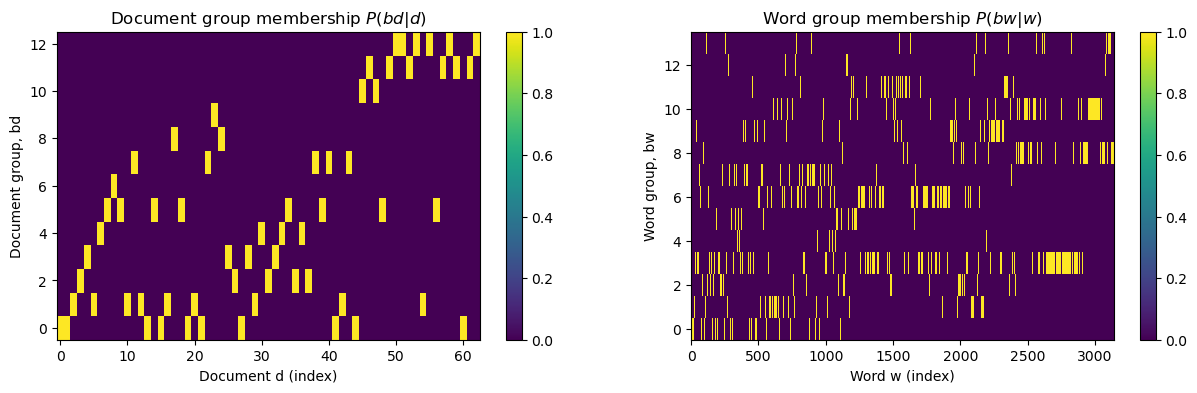

In [12]:
p_td_d,p_tw_w = model.group_membership(l=1)

plt.figure(figsize=(15,4))
plt.subplot(121)
plt.imshow(p_td_d,origin='lower',aspect='auto',interpolation='none')
plt.title(r'Document group membership $P(bd | d)$')
plt.xlabel('Document d (index)')
plt.ylabel('Document group, bd')
plt.colorbar()

plt.subplot(122)
plt.imshow(p_tw_w,origin='lower',aspect='auto',interpolation='none')
plt.title(r'Word group membership $P(bw | w)$')
plt.xlabel('Word w (index)')
plt.ylabel('Word group, bw')
plt.colorbar()

# Relative topical distribution

Compare the frequency $f^i_d$ of words from topic $i$ in document $d$ with the expected value across all documents:

$$ \tau_d^i = (f^i_d -\langle f^i \rangle ) / \langle f^i \rangle $$

as in Eq. (10) of Hyland et al.

In [13]:
model.print_overview()

Level 0 has 39 document groups and 84 topics (word groups)
Level 1 has 13 document groups and 14 topics (word groups)
Level 2 has 2 document groups and 3 topics (word groups)
Level 3 has 1 document groups and 1 topics (word groups)



In [14]:
model.topics(l=2)

{0: [('the', 0.1304471892707187),
  ('of', 0.07362113244466185),
  ('and', 0.04573804573804574),
  ('a', 0.04272145448616037),
  ('to', 0.04141698259345318),
  ('in', 0.039908686967510494),
  ('is', 0.03306020953079777),
  ('for', 0.017447311564958625),
  ('as', 0.016265133912192736),
  ('that', 0.013167013167013167)],
 1: [('formula', 0.02083944819489287),
  ('field', 0.009783778495254868),
  ('when', 0.007729185011251345),
  ('physics', 0.0067508071617258586),
  ('energy', 0.0066529693767733095),
  ('analysis', 0.006359456021915664),
  ('electron', 0.0059681048821054695),
  ('mass', 0.0058702670971529205),
  ('quantum', 0.005576753742295274),
  ('law', 0.005576753742295274)],
 2: [('protein', 0.02806946688206785),
  ('data', 0.017568659127625202),
  ('structure', 0.015751211631663976),
  ('computational', 0.015549273021001616),
  ('bioinformatics', 0.01474151857835218),
  ('biology', 0.01029886914378029),
  ('sequence', 0.009491114701130857),
  ('proteins', 0.009289176090468497),
  (

Relative contribution of topics in each document

In [15]:
print("Document title [relative contribution of each topic]\n")
tau_d=model.topicdist_relative(l=2)

for i in range(len(model.documents)):
    print(model.documents[i],tau_d[i])

Document title [relative contribution of each topic]

Nuclear_Overhauser_effect [-0.13980569  0.57555232 -0.49538507]
Quantum_solvent [ 0.06809446  0.22670045 -0.80523634]
Rovibrational_coupling [-0.10582642  0.61371087 -0.7424699 ]
Effective_field_theory [-0.02818675  0.41790322 -0.72292801]
Chemical_physics [-0.09703426  0.67649061 -0.91560241]
Rotational_transition [-0.05899796  0.59597849 -0.93784674]
Dynamic_nuclear_polarisation [-0.17109143  0.78734273 -0.77754163]
Knight_shift [-0.15027516  0.74804814 -0.79955574]
Polarizability [-0.11599365  0.61549243 -0.69578105]
Anisotropic_liquid [ 0.07901567  0.07904206 -0.5545683 ]
Rotating_wave_approximation [-0.00589727  0.46136675 -0.92305402]
RRKM_theory [ 0.0982838   0.04050484 -0.57047658]
Molecular_vibration [-0.07950154  0.55947082 -0.76092466]
Fuel_mass_fraction [-0.2643075   1.11884623 -1.        ]
Electrostatic_deflection_(structural_element) [-0.11414146  0.58259502 -0.63705565]
Magic_angle_(EELS) [-0.07988048  0.54317796 -0.7

Documents associated to each of the topics

In [16]:
model.docs_of_topic(l=2, n=10)


Topic 0
[0.38049064650371833, 'Folding@home']
[0.0982838041661571, 'RRKM_theory']
[0.08640618551980356, 'Law_of_Maximum']
[0.08143498489053753, 'Molecular_beam']
[0.07901566725096126, 'Anisotropic_liquid']
[0.0680944560439678, 'Quantum_solvent']
[0.050216316701558475, 'Foldit']
[0.04937237968912177, 'Complementary_experiments']
[0.04529642764936884, 'Holometer']
[0.04185241980407554, 'Philosophical_interpretation_of_classical_physics']

Topic 1
[1.1188462256850868, 'Fuel_mass_fraction']
[0.8937188142060465, 'McConnell_equation']
[0.8108969113487717, "Euler's_laws_of_motion"]
[0.7873427314160522, 'Dynamic_nuclear_polarisation']
[0.7601873593581843, 'X-ray_standing_waves']
[0.7585469237949426, 'Einstein–de_Haas_effect']
[0.7480481361901968, 'Knight_shift']
[0.6903835734029293, 'X-ray_crystal_truncation_rod']
[0.6764906101473233, 'Chemical_physics']
[0.6509343508462969, 'Empirical_formula']

Topic 2
[3.008885298869144, 'Journal_of_Computational_Biology']
[2.6602865772283484, 'IEEE/ACM_Tr